# Predict the closing price, Model: SARIMAX, Stock Token: FPT, Train/Test/Validation/: 60/20/20
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 971.20
- MAE: 638.93
- MAPE: 0.84 %

### Import neccesary libraries


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [8]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [9]:
# Choose the split_type and stock_name -> FPT - 6 2 2
split = 2  # 6 2 2
stock = 0  # FPT

## 1.Data preprocessing


In [10]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1247,2024-02-26,103900,108000,103500,108000,4466700,FPT
1248,2024-02-27,108500,109500,107400,107900,2800800,FPT
1249,2024-02-28,108000,108500,106300,108500,3461700,FPT
1250,2024-02-29,108200,109400,107700,109000,2824800,FPT


In [11]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [12]:
df.reset_index(drop=True)
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [13]:
# Shape of the dataframe
df.shape

(1252, 2)

In [14]:
df.dtypes

low      int64
close    int64
dtype: object

In [15]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,53176.075879,53761.785144
std,23775.452690,24036.800576
min,19080.000000,19190.000000
25%,28000.000000,28170.000000
50%,61120.000000,62070.000000
75%,69047.500000,69670.000000
max,109100.000000,110800.000000


## 2. Train model


In [16]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [17]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [18]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

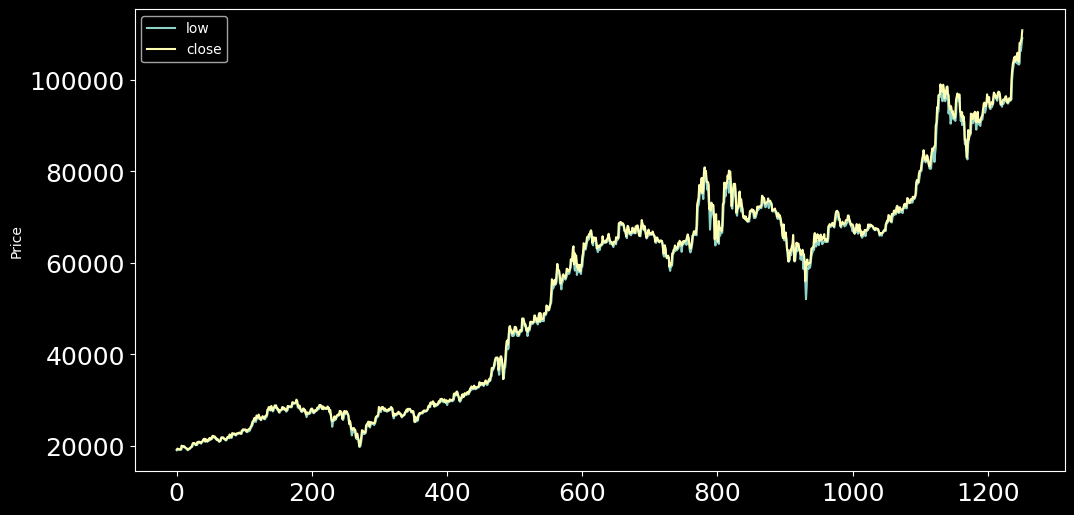

In [19]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [20]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.7303295005214733,
 0.9904241120961623,
 15,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 20395.460496469426)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [21]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [22]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.893
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.879
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


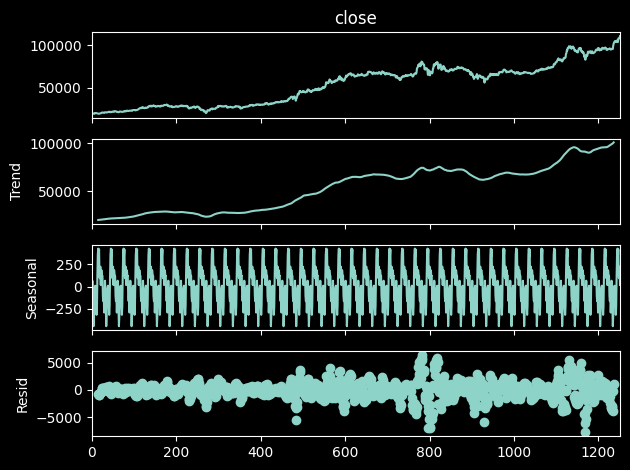

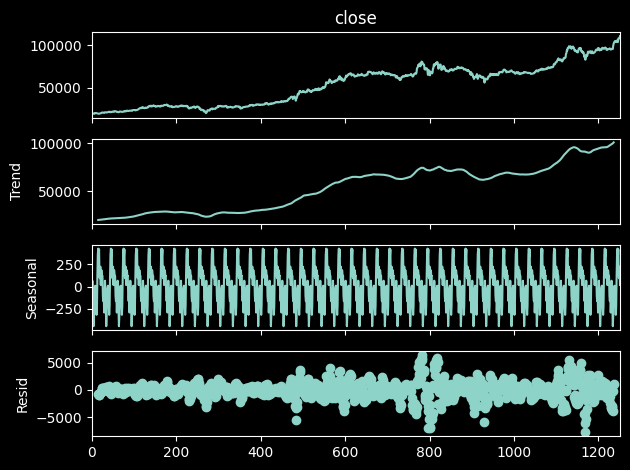

In [23]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [24]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [25]:
# Check again
adfuller(df_diff)

(-7.81878510085306,
 6.75727597765823e-12,
 22,
 977,
 {'1%': -3.43706091543889,
  '5%': -2.8645028204932483,
  '10%': -2.568347558984588},
 16108.646453189835)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

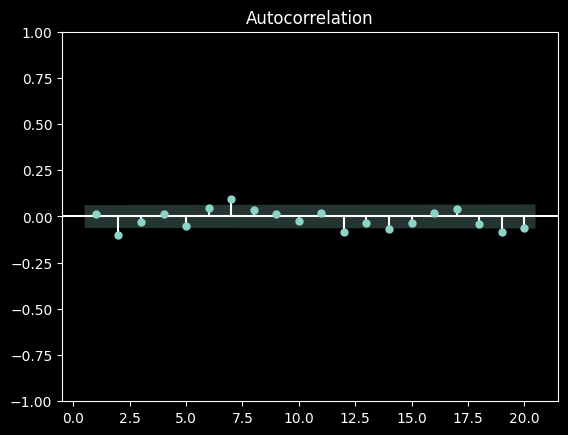

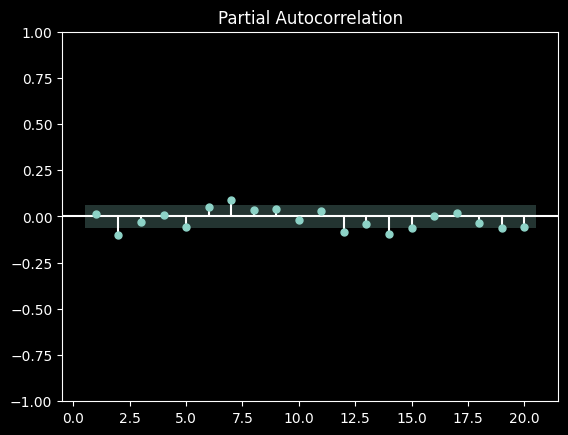

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [27]:
# Review the dataset again
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [28]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=16492.501, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16493.296, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=16494.600, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=16494.390, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16494.136, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=16490.895, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=16491.287, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=16491.587, Time=0.89 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=16490.992, Time=0.42 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=16493.393, Time=1.23 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=16489.847, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=16489.773, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=16489.884, Time=0.18 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=16491.790, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0

In [29]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1001
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 5)   Log Likelihood               -8239.076
Date:                             Sat, 25 May 2024   AIC                          16488.152
Time:                                     22:29:52   BIC                          16512.691
Sample:                                          0   HQIC                         16497.479
                                            - 1001                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     54.1271     26.452      2.046      0.041       2.281     105.973
ma.L1          0.0129      

#### Use SARIMAX to train model


In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

### Test


In [31]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([68422.36108994, 67442.19953753, 67111.71827255, 67652.06295832,
       67380.29847729, 67983.4458694 , 67821.07244751, 67095.00970768,
       67425.03822578, 67896.50753736, 67340.1737497 , 67500.47331564,
       66698.97548596, 66293.511878  , 66698.97548596, 66698.97548596,
       67019.57461783, 67425.03822578, 66623.54039611, 67500.47331564,
       67660.77288157, 67821.07244751, 67896.50753736, 68622.57027719,
       68386.8356214 , 68858.30493297, 68622.57027719, 68698.00536704,
       68698.00536704, 68547.13518733, 68056.8071033 , 68056.8071033 ,
       67821.07244751, 67981.37201344, 68056.8071033 , 67981.37201344,
       68056.8071033 , 67821.07244751, 67255.30927362, 66698.97548596,
       67095.00970768, 67179.87418377, 66698.97548596, 67179.87418377,
       67340.1737497 , 67500.47331564, 67821.07244751, 67821.07244751,
       67660.77288157, 69348.63301701, 69263.76854093, 69499.50319672,
       69744.66723874, 70065.26637061, 70225.56593654, 69744.66723874,
      

#### Validate


In [32]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 91995.82666872,  92335.77918873,  95164.14231131,  95798.78085939,
        95291.28172257,  96563.91553711,  95996.07850727,  94393.08284791,
        96373.25395653,  96373.25395653,  94581.67057254,  94393.08284791,
        94770.25829718,  94958.84602181,  97410.486442  ,  95336.02147107,
        91847.14856541,  93450.14422476,  92318.61787698,  89772.68359447,
        90715.62221762,  92035.73629004,  91281.38539151,  90809.91607994,
        90621.32835531,  90904.20994225,  90338.44676836,  91469.97311615,
        94487.37671023,  94958.84602181,  95053.13988412,  94393.08284791,
        95336.02147107,  92318.61787698,  90338.44676836,  91281.38539151,
        89489.80200753,  90149.85904373,  90149.85904373,  90244.15290605,
        85623.75365261,  85906.63523955,  84680.81502946,  82794.93778315,
        82417.76233389,  85529.45979029,  86566.69227576,  87321.04317428,
        87415.33703659,  87792.51248585,  91092.79766688,  90621.32835531,
        89866.97745679,  

### Predict the next 30/60/90 days


In [33]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [34]:
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1247,103500,108000
1248,107400,107900
1249,106300,108500
1250,107700,109000


In [35]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[91911.38308842 92027.56746625 92086.22816414 92119.92312079
 92143.00674032 92248.93378954 92305.97337835 92365.08682312
 92424.20026789 92483.31371267 92542.42715744 92601.54060221
 92660.65404698 92719.76749175 92778.88093652 92837.99438129
 92897.10782606 92956.22127083 93015.3347156  93074.44816037
 93133.56160514 93192.67504991 93251.78849468 93310.90193945
 93370.01538422 93429.12882899 93488.24227376 93547.35571853
 93606.4691633  93665.58260807]


### Plotting the data


In [36]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

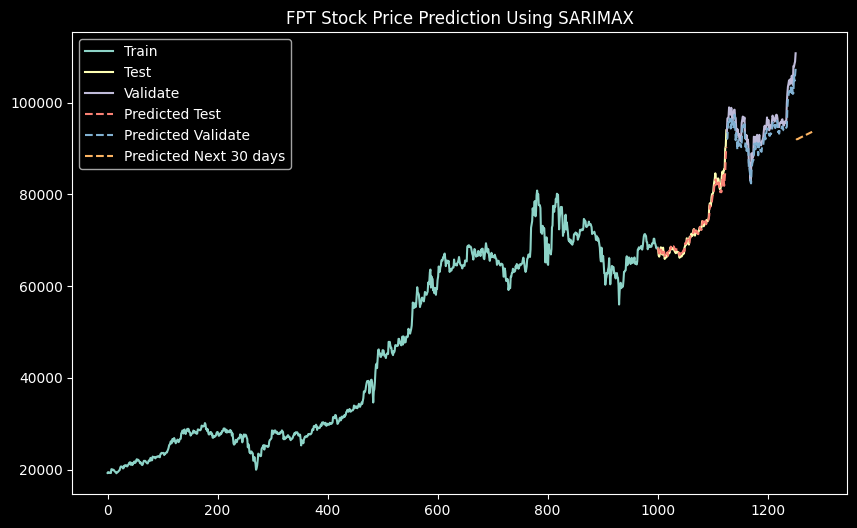

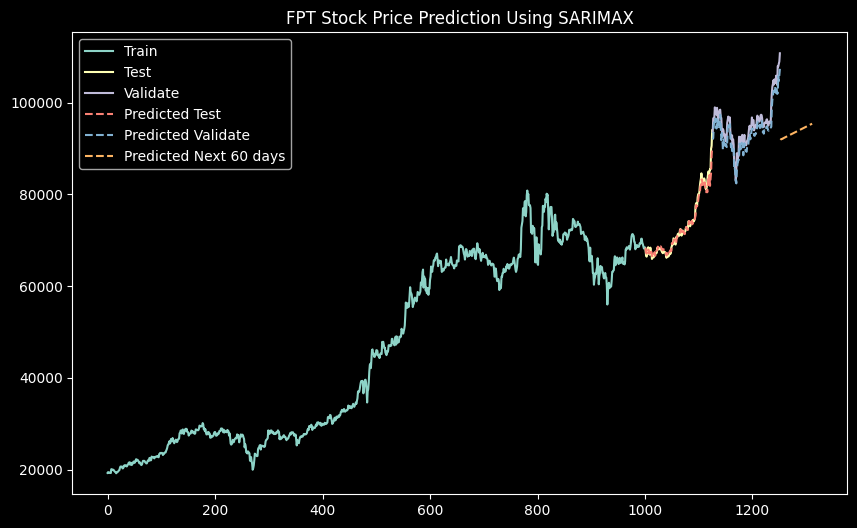

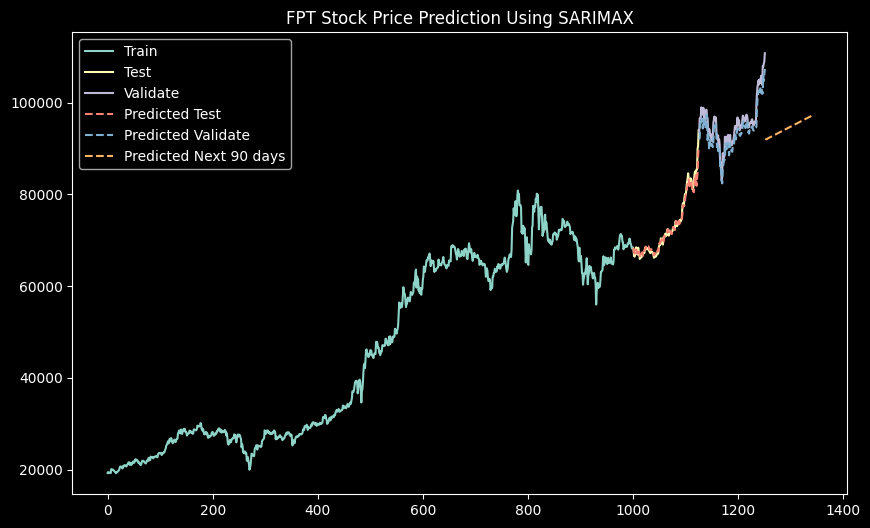

In [38]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [41]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 971.2006388992786
MAE on test data: 638.9265588532827
MAPE on test data: 0.8360668113244889 %


In [42]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 2134.512266455037
MAE on validation data: 1865.9546511023973
MAPE on validation data: 1.9335646341758599 %
